# Bayesian Experimental Design of Soft X-Ray Crystal Spectroscopy of Sight

In this demo, we are aiming to design a diagnostic system for understanding the effective charge, $Z_{eff.}$, of a plasma in the tokamak ST-40.

## Background

The plasma's effective charge changes due to impurities present in the core plasma. These will emit photons which can be captured by Soft X-Ray Crystal Spectroscopy (XRCS).

*Forward models* can predict a diagnostic measurement from a certain plasma state. [INDICA](https://github.com/indica-mcf/Indica) contains such a model for the XRCS.

Using INDICA, various impurity emission states have been modelled throughout a flat top equilibrium from ST-40. Examples of these are shown below.


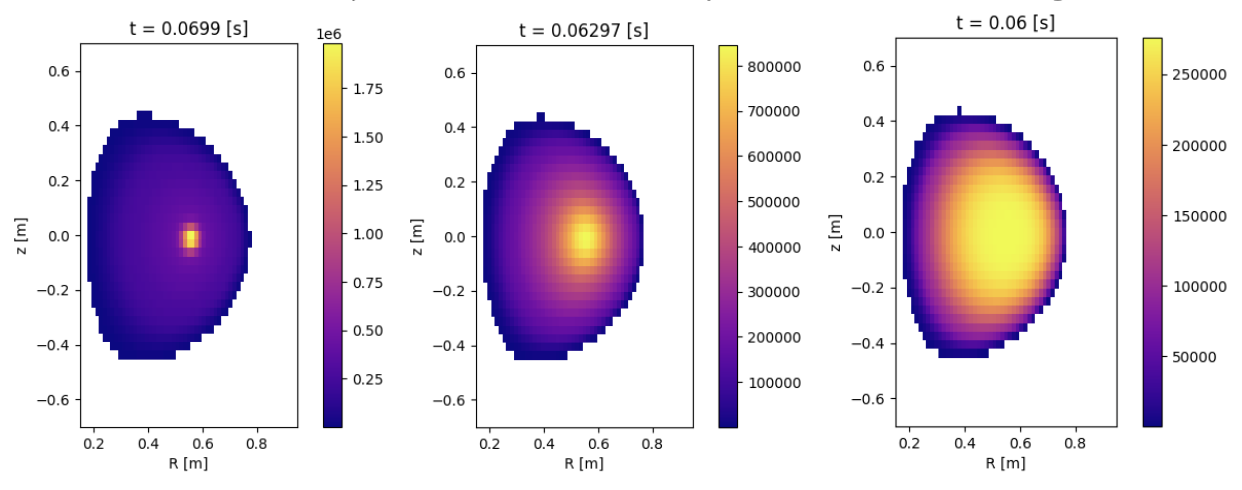


The XRCS system fans spectroscopic lines of sight (LoS) throughout the poloidal plane. Due to limited port space available for diagnostics, these lines of sight originate from a single location.

In this toy problem, we imagine the scenario where the port location is fixed and there is only the capacity to include three lines of sight from the twenty four options available.

We wish to identify the best three lines of sight from a fan of an x-ray camera system from the twenty four candidate lines of sight (left). We refer to each configuration of three lines of sight as a sensor set.

### Mission:
Can we identify the three *best* lines of sight to include in our XRCS system such that we give experimentalists the best prospect of measuring the plasma's effective charge in future experiments?


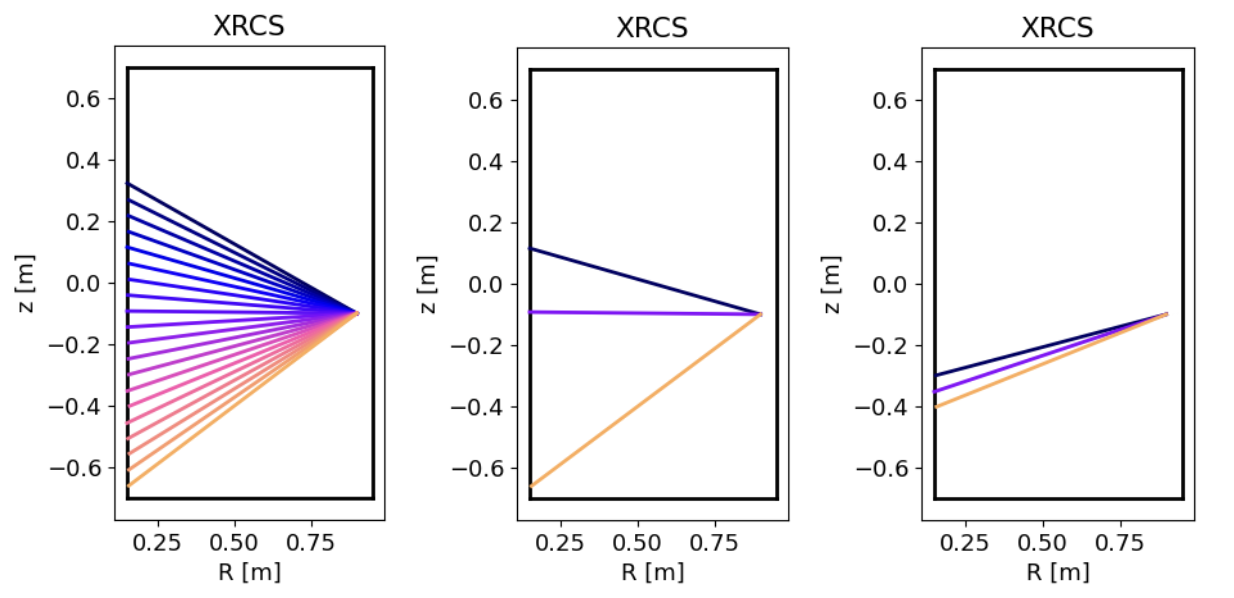


There are different definitions of the best sensor set.

In the world of Bayesian experimental design, the <strong><i>best</i></strong> sensor set is the one that maximises the <strong>E</strong>xpected <strong>I</strong>nformation <strong>G</strong>ain (EIG) from those sensors' measurements.

With our new framework, this can be achieved in 5 easy steps.
<ol>
    <li>Basic setup</li>
    <li>Define dataset and measurement uncertainty</li>
    <li>Setup the designer</li>
    <li>Suggest a sensor design</li>
    <li>Examine suggested designs</li>
</ol>

## 1. Basic setup

First, we need to download the relevant data for this demo.
<br>
We have hidden this code, but it can be seen by clicking 'Show code'.

In [1]:
import gdown

gdown.download(f"https://drive.google.com/uc?id=139v6NcVIyfABapCid3c-VEuBbKkHnVRx", "Imaging_measurements_handsOn.csv", quiet=True)
gdown.download(f"https://drive.google.com/uc?id=1Qlk8L4sm8UT1F96BTQy0wyJ_lCuSKw4B", "Imaging_geometry_handsOn.csv", quiet=True)
gdown.download(f"https://drive.google.com/uc?id=1MiQUj2g9w7Y5mBXe0k4evFk0yNHJAt_s", "Imaging_states_handsOn.nc", quiet=True)

'Imaging_states_handsOn.nc'

Next, we will import and install all the packages we'll need.<br/>
Again, we have hidden this code, but it can be seen by clicking 'Show code'.

In [1]:
import numpy as np
import pandas as pd

from designer import Designer
from utils import LOSPlotter

## 2. Define dataset and measurement uncertainty

This data-driven approach relies on samples of simulated sensor readings for each candidate sensor configuration. These samples are provided to the framework as a pandas DataFrame imported from a CSV file.

A sensor configuration may vary the physical attributes of the sensor, such as its location or angle, but it can also encompass variations in precision or entirely different types of sensors measuring distinct quantities.

For this demonstration, each candidate sensor configuration corresponds to a unique line of sight. In the DataFrame, each row represents simulated readings at a specific time, while each column corresponds to a simulated sensor.

In [2]:
sensor_df = pd.read_csv("Imaging_measurements_handsOn.csv")
sensor_df

,LoS_0,LoS_1,LoS_2,LoS_3,LoS_4,LoS_5,LoS_6,LoS_7,LoS_8,LoS_9,...,LoS_15,LoS_16,LoS_17,LoS_18,LoS_19,LoS_20,LoS_21,LoS_22,LoS_23,LoS_24
0,38190.24508,41991.01584,45894.25081,49932.22124,54051.27682,58168.33683,62236.46927,66200.97637,70044.88814,73666.87664,...,84854.11416,83477.50032,80826.27209,76950.46973,72133.87904,66632.02633,60690.99607,54455.51186,47966.08847,41046.33741
1,61079.91936,67208.76267,73482.80635,79934.01737,86446.55834,92858.82916,99054.48577,104906.51170,110327.04260,115126.88910,...,124767.04810,122545.35320,119154.80860,114564.41880,108927.30970,102263.60860,94621.25573,86003.38315,76424.85676,65691.36885
2,43364.56751,47621.27276,51957.17277,56392.56637,60846.17998,65202.92790,69382.82393,73299.71215,76904.48889,80073.65952,...,86364.27936,84820.42439,82452.99190,79257.14789,75375.17356,70851.05996,65720.27836,59956.45374,53526.58996,46247.30659
3,28997.47283,31762.89548,34564.19064,37414.43235,40262.50296,43032.83857,45677.55316,48147.86521,50436.42237,52489.68638,...,58960.07122,58009.93556,56062.33682,53269.41381,50014.43791,46573.80601,43036.17994,39300.31768,35226.73019,30605.92850
4,42057.35704,46176.54190,50371.76170,54664.94838,58982.22467,63220.69832,67320.52725,71225.68125,74937.47104,78400.35202,...,91363.73001,89974.70214,86780.06805,82032.64642,76398.79654,70437.12136,64440.78248,58339.75869,51919.43886,44826.90630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,30130.49005,33120.48451,36196.26283,39385.68794,42650.43032,45924.96113,49171.22372,52341.47927,55420.07063,58314.48885,...,66867.41435,65768.02650,63722.28849,60750.88796,57037.58333,52746.87448,48048.64564,43073.34901,37885.75962,32379.67849
999,52130.05752,57304.93208,62591.99891,68020.83399,73499.39274,78900.02356,84143.19945,89147.35892,93881.78156,98232.22773,...,111029.63770,109202.02410,105755.68560,100799.40450,94768.99784,88010.68094,80779.52442,73105.16387,64898.78798,55852.21536
1000,47534.44199,52266.98346,57107.60645,62082.00874,67103.08601,72045.38636,76819.24473,81325.03334,85498.16212,89187.85396,...,96429.19753,94703.23500,92097.53590,88582.62835,84266.55138,79155.86571,73278.32425,66640.42563,59260.17200,50989.65802
1001,50769.92968,55780.40351,60884.07219,66101.18250,71330.40130,76431.47822,81302.62886,85835.73176,89961.82671,93534.13226,...,99864.78911,98058.54001,95373.84173,91806.41782,87507.41092,82490.20507,76742.02670,70178.63628,62739.70480,54223.18124


We must also define the expected uncertainty of our sensor measurements. This can include instrumental uncertainties and uncertainties in the forward model used to predict the measurements.<br>Here, we will use 5% of the median measurement. When optimising real-world sensors, consult each candidate sensor's datasheet for its precision or uncertainty.

In [3]:
sigma = float(0.05 * np.median(sensor_df.values))
sigma

3180.2221795000005

In [4]:
qoi_df = pd.read_csv("qoi_z_eff.csv")
qoi_df

,Z_eff_max,Z_eff_ave
0,2.486190,1.935552
1,2.922230,2.402350
2,2.298717,1.944746
3,2.000748,1.623339
4,2.715367,2.016006
...,...,...
998,2.137163,1.719412
999,2.915605,2.246450
1000,2.457835,2.064830
1001,2.477908,2.103732


We have added some plotting functionality to allow this data to be visualised.

On the left hand side, we have the emission distributions for the different plasma states and the corresponding average effective charge is displayed.

On the right hand side, we have the corresponding XRCS measurements for the possible lines of sight (as modelled by INDICA).

Please use the slider along the top to visualize the different plasma states in our dataset.

In [4]:
#  Visualise the sensor data
plotter = LOSPlotter(sensor_df)
plotter.display_plot()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

### Beat the designer!

Before we make our suggestion for the optimal sensor set, we challenge you to beat our designer! Which three sensors would you choose?

Use the plotting visualisation to decide your choice of sensors. Can your chosen sensors differentiate between the different plasma states?

In [5]:
plotter.display_interactive_plot()

interactive(children=(IntSlider(value=0, description='run', max=1002), SelectMultiple(description='Click while…

Output()

## 3. Setup the designer

To access this cloud tool, your registered email is required.<br> **If you have not been registered speak to a member of the team for assistance.**

We will provide the designer with our dataset of observable quantities, the expected uncertainty on these observable quantities.

In [5]:
email = "ethan@digilab.ai"  # ENTER YOUR EMAIL HERE
designer = Designer(email=email, observables=sensor_df, sigma=sigma, quantities_of_interest=qoi_df)

## 4. Get suggested sensor designs

Define the number of sensors you wish to place and how many different sensor sets you wish to evaluate. Using a genetic algorithm, sensor sets are intelligently selected for evaluation.

The top 5 of the evaluated sensor sets is returned for examination.

Let's suggest some 3-sensor sets after evaluating 100 different sets.<br/><br/>
(This should take approximately 4 minutes, in the meantime you can think more about which sensors you would choose.)

In [9]:
suggestions = designer.suggest(num_sensors=3, num_eval=100)
suggestions

{('LoS_5', 'LoS_8', 'LoS_16'): {'mean_score': 2.4909492552800403,
  'score_var': 0},
 ('LoS_7', 'LoS_12', 'LoS_16'): {'mean_score': 2.4893717320789612,
  'score_var': 0.0010726572485454983},
 ('LoS_7', 'LoS_15', 'LoS_16'): {'mean_score': 2.485962341393602,
  'score_var': 0.00010625049379524313},
 ('LoS_5', 'LoS_10', 'LoS_15'): {'mean_score': 2.482880928909004,
  'score_var': 0.00040792843518564176},
 ('LoS_7', 'LoS_15', 'LoS_18'): {'mean_score': 2.479580118066397,
  'score_var': 0}}

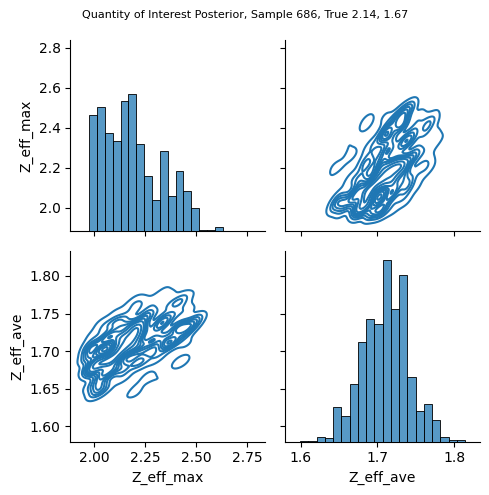

In [15]:
designer.visualise_posterior(list(suggestions.keys())[0])

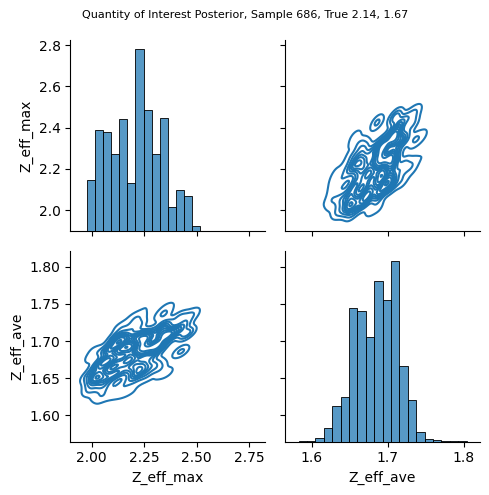

In [16]:
designer.visualise_posterior(list(suggestions.keys())[4], sample=686)

### 5. Examine suggested designs

While some sensor sets are much better than others, it is possible there are several that perform similarly well. Instead of just recommending the *best* sensor set, we empower you with the insights and tools to make an informed decision yourself.

Let's begin by <strong>visualising the suggested sensor sets</strong> to build intuition about the features that contribute to higher information gain.

In [9]:
# Line of sight visualisation here
plotter.display_plot(list(suggestions.keys())[0])

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

Next let's <strong>visualise the distribution of Expected Information Gain (EIG) scores</strong> of the evaluated sensor sets, providing valuable insights for decision-making:

<ol>
    <li><strong>Cluster Identification:</strong> Identify clusters of high-performing sets for further examination</li>
    <li><strong>Distribution Width:</strong> A narrow distribution suggests flexibility, while a broad one signals the need for careful placement.</li>
    <li><strong>Decision Confidence:</strong> Gain confidence in the robustness of a chosen sensor set based on its position relative to other evaluated sets.</li>
</ol>

In [10]:
designer.visualise_score_distribution_dg()

/Users/ethanhargrove/Desktop/repos/STEPControl-Use-Cases/ImagingDemo/notebooks/designer.py:59: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



We found that several sensor sets performed similarly well.
Due to the limited number of sensors, there is no space for redundant sensors. However, what happens if sensors could get damaged? How tolerant are our suggested sensor sets to failure of one of the sensors?

This can be investigated through <strong>redundancy analysis</strong> on the suggested designs. This helps:

<ol>
    <li><strong>Resilience Assessment:</strong> Determine how resilient a sensor set is to failure. If performance drops significantly when a sensor is removed, the system is less robust.</li>
    <li><strong>Failure Tolerance:</strong> Allows you to assess which set can better tolerate individual sensor failures.</li>
    <li><strong>Critical Sensor Identification:</strong> Identify the most critical sensors, helping prioritize maintenance or redundancy planning.</li>
</ol>

Below, we will perform redundancy analysis for our suggested sensor set.

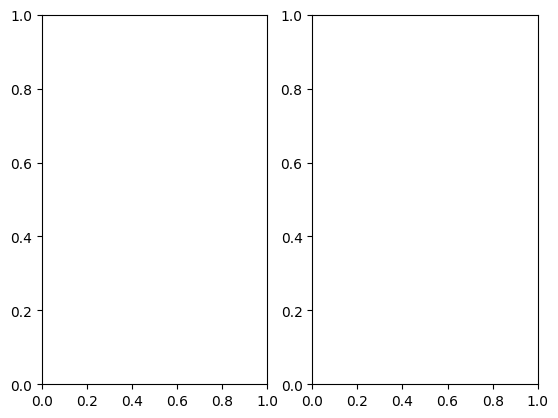

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

interactive(children=(IntSlider(value=0, description='run', max=1002), Output()), _dom_classes=('widget-intera…

Output()

In [11]:
designer.redundancy_analysis([list(s) for s in list(suggestions.keys())[:2]], num_iter=2)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, CheckButtons

# Create interactive plot with matplotlib widgets
def create_interactive_plot():
    # Create figure and subplots
    fig = plt.figure(figsize=(10, 8))
    
    # Main axes for plotting
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    
    # Axes for sliders
    ax_amp = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
    ax_amp.set_position([0.25, 0.1, 0.65, 0.03])  # [left, bottom, width, height]
    
    ax_freq = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
    ax_freq.set_position([0.25, 0.15, 0.65, 0.03])
    
    # Axes for checkboxes
    ax_check = plt.subplot2grid((3, 1), (2, 0))
    ax_check.set_position([0.05, 0.2, 0.1, 0.15])
    ax_check.axis('off')
    
    # Generate x values
    x = np.linspace(0, 10, 100)
    
    # Initial plot data
    amplitude = 1.0
    frequency = 1.0
    sin_line, = ax.plot(x, amplitude * np.sin(frequency * x), label='Sine', color='blue')
    cos_line, = ax.plot(x, amplitude * np.cos(frequency * x), label='Cosine', color='red')
    
    # Tangent needs special treatment due to its range
    y_tan = amplitude * np.tan(frequency * x)
    y_tan = np.clip(y_tan, -5, 5)
    tan_line, = ax.plot(x, y_tan, label='Tangent (clipped)', color='green')
    
    # Set plot properties
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Interactive Trigonometric Functions')
    ax.grid(True)
    ax.legend()
    ax.set_ylim(-5, 5)
    
    # Create sliders
    amp_slider = Slider(ax_amp, 'Amplitude', 0.1, 3.0, valinit=amplitude, valstep=0.1)
    freq_slider = Slider(ax_freq, 'Frequency', 0.1, 3.0, valinit=frequency, valstep=0.1)
    
    # Create checkboxes
    check = CheckButtons(ax_check, ['Sine', 'Cosine', 'Tangent'], [True, True, True])
    
    # Update function for sliders
    def update(val):
        amp = amp_slider.val
        freq = freq_slider.val
        
        # Update data
        sin_line.set_ydata(amp * np.sin(freq * x))
        cos_line.set_ydata(amp * np.cos(freq * x))
        
        # Update tangent with clipping
        y_tan = amp * np.tan(freq * x)
        y_tan = np.clip(y_tan, -5, 5)
        tan_line.set_ydata(y_tan)
        
        fig.canvas.draw_idle()
    
    # Update function for checkboxes
    def func(label):
        if label == 'Sine':
            sin_line.set_visible(not sin_line.get_visible())
        elif label == 'Cosine':
            cos_line.set_visible(not cos_line.get_visible())
        elif label == 'Tangent':
            tan_line.set_visible(not tan_line.get_visible())
            
        fig.canvas.draw_idle()
    
    # Connect callbacks
    amp_slider.on_changed(update)
    freq_slider.on_changed(update)
    check.on_clicked(func)
    
    plt.show()

# Create the interactive plot
create_interactive_plot()

<IPython.core.display.Javascript object>

FloatSlider(value=1.0, description='Amplitude', max=5.0, min=0.1)

interactive(children=(FloatSlider(value=1.0, description='Amplitude', max=5.0, min=0.1), Output()), _dom_class…

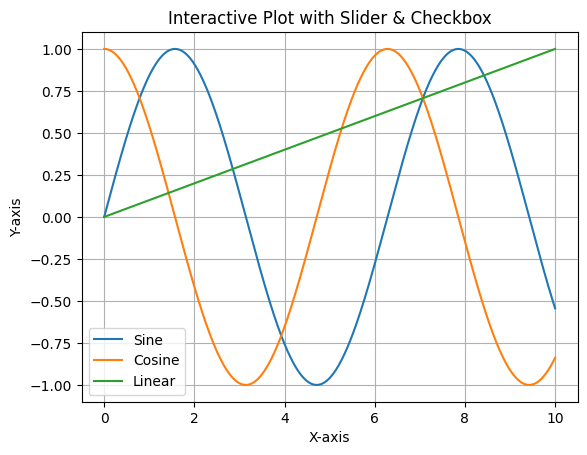

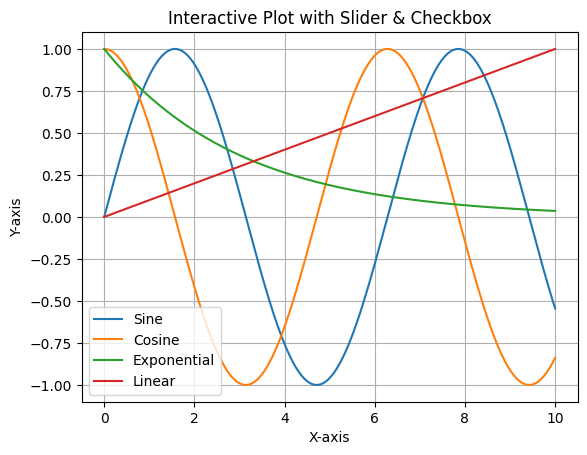

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, HBox, VBox

# Define the x values
x = np.linspace(0, 10, 1000)

# Function to update the plot dynamically
def update_plot(amplitude, selected_curves):
    plt.clf()  # Clear the current plot

    # Define different functions
    functions = {
        'Sine': amplitude * np.sin(x),
        'Cosine': amplitude * np.cos(x),
        'Exponential': amplitude * np.exp(-x / 3),
        'Linear': amplitude * (x / 10),
    }
    
    # Plot only the selected functions
    for label in selected_curves:
        if label in functions:
            plt.plot(x, functions[label], label=label)
    
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Interactive Plot with Slider & Checkbox')
    plt.grid(True)
    plt.show()

# Create a slider for amplitude
amplitude_slider = widgets.FloatSlider(
    value=1, min=0.1, max=5, step=0.1, description='Amplitude'
)

# Create checkboxes for function selection
function_options = ['Sine', 'Cosine', 'Exponential', 'Linear']
checkboxes = [widgets.Checkbox(value=True, description=label) for label in function_options]
checkbox_container = VBox(checkboxes)

# Function to get selected checkboxes
def get_selected():
    return [cb.description for cb in checkboxes if cb.value]

# Interactive function
def interactive_update(amplitude):
    selected = get_selected()
    update_plot(amplitude, selected)

# Attach event listeners
for cb in checkboxes:
    cb.observe(lambda change: interactive_update(amplitude_slider.value), names='value')

# Display widgets
display(amplitude_slider, checkbox_container)

# Attach the interactive function to the slider
widgets.interactive(interactive_update, amplitude=amplitude_slider)


In [2]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    "A": [1, 2, 3],
    "B": [4, 5, 6],
    "C": [7, 8, 9],
    "D": [10, 11, 12]
})

# List of column names whose indices we need
sublist = ["B", "D"]

# Get indices
indices = [df.columns.get_loc(col) for col in sublist]

print(indices)  # Output: [1, 3]


[1, 3]


In [8]:
df.iloc[np.array([0,1,0,0,0,0])]

,A,B,C,D
0,1,4,7,10
1,2,5,8,11
0,1,4,7,10
0,1,4,7,10
0,1,4,7,10
0,1,4,7,10
